In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score as AUC

## 加载数据

In [30]:
boston = load_boston()

In [31]:
X = boston.data
Y = boston.target

In [32]:
df = pd.DataFrame(X, columns=boston.feature_names)

In [33]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [35]:
# 划分数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y
                                                    , test_size = 0.2
                                                    , random_state=20
                                                   )

## 建模

### 原生接口

In [36]:
# 转换指定数据类型
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test)

In [37]:
# 指定参数

params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",  # 回归任务
    "metric": {"l2", "auc", "mse"},
    "num_leaves": 31,  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    "learning_rate": 0.2,
    "feature_fraction": 0.9,  # 建树的特征选择比例
    "bagging_fraction": 0.8,  # 建树的采样比例
    "bagging_freq": 5,  # K意味着每k次迭代执行bagging
    "verbose": 1,
    "force_row_wise":True
}

In [38]:
# training model
gbm =lgb.train(params=params, train_set=lgb_train
          , num_boost_round=200
          , valid_sets=lgb_eval
          , early_stopping_rounds=5
         )

[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 13
[LightGBM] [Info] Start training from score 22.763614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 48.0376	valid_0's auc: 1
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 36.7234	valid_0's auc: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 28.6088	valid_0's auc: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 24.1804	valid_0's auc: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 21.2078	valid_0's auc: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l2: 18.3789	valid_0's auc: 1
Early stopping, best iteration is:
[1]	valid_0's l2: 

In [39]:
# 保存模型
joblib.dump(gbm, "./data/lgb.pkl")

['./data/lgb.pkl']

In [40]:
gbm.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('l2', 48.03756784158355),
                          ('auc', 1.0)])})

In [41]:
# 评估指标
MSE(Y_test, gbm.predict(data=X_test))

48.03756704218638

### sklearn接口

In [42]:
gbm = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05)
gbm.fit(X_train, Y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
# 评估指标
MSE(Y_test, gbm.predict(X_test))

11.827460665407331

In [44]:
# 特征重要性
feature_import = pd.DataFrame(gbm.feature_importances_
                              , index=df.columns
                              , columns=["score"]
                             )
feature_import.sort_values(by="score", ascending=False)

,score
RM,258
LSTAT,257
DIS,188
NOX,158
AGE,141
CRIM,124
B,101
PTRATIO,100
TAX,85
INDUS,49


In [45]:
# 网格搜索
estimator = lgb.LGBMRegressor(num_leaves=31)
param_grid = {
    "learning_rate": [0.1, 0.001, 1],
    "n_estimators": [20, 40]
}

In [46]:
gbm = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5)
gbm = gbm.fit(X_train, Y_train)

In [47]:
gbm.best_params_

{'learning_rate': 0.1, 'n_estimators': 40}

In [48]:
gbm.cv_results_["mean_test_score"]

array([0.80063736, 0.84075044, 0.02038632, 0.04988975, 0.79189116,
       0.79570676])

In [49]:
gbm.best_score_

0.8407504431796051

### CV交差验证调参
0. 确定任务类型(回归、分类、排序等)，以及基学习器的类型(dark, gbdt、RF)  
1. 首先选择较高的学习率，大概0.1附近，这样是为了加快收敛的速度。这对于调参是很有必要的。
2. 对决策树基本参数调参
3. 正则化参数调参
4. 最后降低学习率，这里是为了最后提高准确率


#### 加载数据

In [74]:
cancer = load_breast_cancer()
X = cancer.data
Y = cancer.target

# 划分数据集
X_train, X_val, Y_train, Y_val = train_test_split(X, Y
                                                    , test_size = 0.2
                                                    , random_state=20
                                                   )

In [86]:
# 数据类型转换
data_train = lgb.Dataset(X_train, Y_train)
data_val = lgb.Dataset(X_val, Y_val)

#### 初始化状态(未调参)

In [87]:
# 参数设定为默认状态

params1 = {
      "boosting_type": "gbdt"
    , "objective": "binary" # 二分类任务
    , "metric": {"binary_logloss","auc"}
    
    , "device": "gpu"
    , 'gpu_platform_id': 0
    , 'gpu_device_id': 0
    , "num_gpu": 1
    
#     , "nthread": 
#     , "verbose": 1

#     , "learning_rate": 0.1
    
    , "max_depth": 2
    , "num_leaves": 2  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
#     , "subsample": 1.0  # 数据采样
#     , "colsample_bytree": 1.0  # 特征采样
    
    , 'reg_alpha': 0.0  # L1
    , 'reg_lambda': 0.0  # L2
}

In [88]:
cv_result1 = lgb.cv(params=params1, train_set=data_train
       , nfold=5
       , stratified=True
       , shuffle=True
#        , metrics="auc"
       , early_stopping_rounds=2
       , seed=0
      )

[LightGBM] [Info] Number of positive: 232, number of negative: 132
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4536
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: GeForce GTX 950M, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.01 MB) transferred to GPU in 0.000857 secs. 0 sparse feature groups
[LightGBM] [Info] Number of positive: 233, number of negative: 131
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4536
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: GeForce GTX 950M, Ven

#### 调整好的参数状态

In [54]:
num_boost_round = 1000
params2 = {
      "boosting_type": "gbdt"
    , "objective": "binary" # 二分类任务
    , "metric": {"binary_logloss","auc"}
    
    , "nthread": 4
    , "verbose": 1

    , "learning_rate": 0.1
    
    , "max_depth": 5
    , "num_leaves": 31  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    , "subsample": 1.0  # 数据采样
    , "colsample_bytree": 1.0  # 特征采样
    
    , 'reg_alpha': 0.0  # L1
    , 'reg_lambda': 0.0  # L2
}

In [55]:
cv_result2 = lgb.cv(params=params2, train_set=data_train
#        , num_boost_round=num_boost_round
       , nfold=5
       , stratified=True
       , shuffle=True
#        , metrics="auc"
#        , early_stopping_rounds=50
       , seed=0
      )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 232, number of negative: 132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4536
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 233, number of negative: 131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tot

In [56]:
#  选择最佳的estimators
print("Best_n_estimators: %d\nBest_cv_score: %.2f" 
      % (np.array(list(cv_result2.values())).shape[1],
         max(np.array(list(cv_result2.values()))[0])*100)
     )  

Best_n_estimators: 100
Best_cv_score: 58.36


#### 此时可参数的状态

In [57]:
params3 = {
      "boosting_type": "gbdt"
    , "objective": "binary" # 二分类任务
    , "metric": {"binary_logloss","auc"}
    
    , "nthread": 4
    , "verbose": 1

    , "learning_rate": 0.1
    
    , "max_depth": 5
    , "num_leaves": 31  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    , "subsample": 1  # 数据采样
    , "colsample_bytree": 1  # 特征采样
    
    , 'reg_alpha': 0.0  # L1
    , 'reg_lambda': 0.0  # L2
}

In [58]:
cv_result3 = lgb.cv(params=params3, train_set=data_train
#        , num_boost_round=1000
       , nfold=5
       , stratified=True
       , shuffle=True
#        , metrics="auc"
#        , early_stopping_rounds=50
       , seed=0
      )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 232, number of negative: 132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4536
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 233, number of negative: 131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tot

In [59]:
cv_result3.keys()

dict_keys(['binary_logloss-mean', 'binary_logloss-stdv', 'auc-mean', 'auc-stdv'])

#### 可视化调参数过程

In [93]:
def plot_mertics(cv_result1, cv_result2, cv_result3, index1=0, index2=1):
    """绘制评估曲线"""
    
    fig, ax = plt.subplots(1, 2, figsize = (14,5))

    length1 = np.array(list(cv_result1.values())).shape[1]
    length2 = np.array(list(cv_result2.values())).shape[1]
    length3 = np.array(list(cv_result3.values())).shape[1]

    ax[0].plot(range(length1), cv_result1[list(cv_result1.keys())[index1]], label="param1", c="red")
    ax[1].plot(range(length1), cv_result1[list(cv_result1.keys())[index2]], label="param1", c="green")

    ax[0].plot(range(length2), cv_result2[list(cv_result2.keys())[index1]], label="param2", c="magenta")
    ax[1].plot(range(length2), cv_result2[list(cv_result2.keys())[index2]], label="param2", c="blue")

    ax[0].plot(range(length3), cv_result3[list(cv_result3.keys())[index1]], label="param3", c="yellow")
    ax[1].plot(range(length3), cv_result3[list(cv_result3.keys())[index2]], label="param3", c="c")

    ax[0].set_xlabel("num_round", fontsize=12)
    ax[1].set_xlabel("num_round", fontsize=12)
    ax[0].set_ylabel(list(cv_result1.keys())[index1], fontsize=12)
    ax[1].set_ylabel(list(cv_result1.keys())[index2], fontsize=12)
    ax[0].legend()
    ax[1].legend()
    
    plt.show()

#### AUC评估

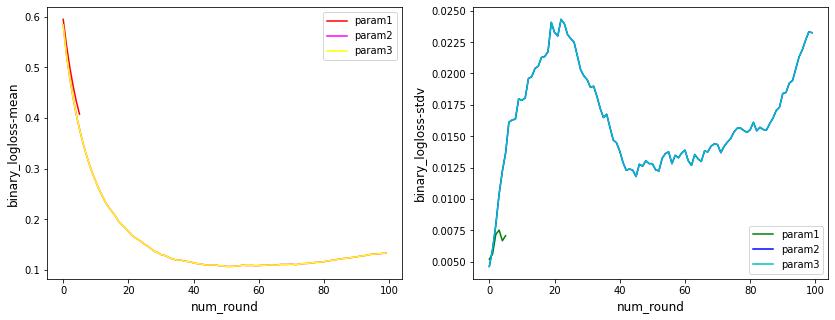

In [94]:
plot_mertics(cv_result1, cv_result2, cv_result3)

#### logloss评估

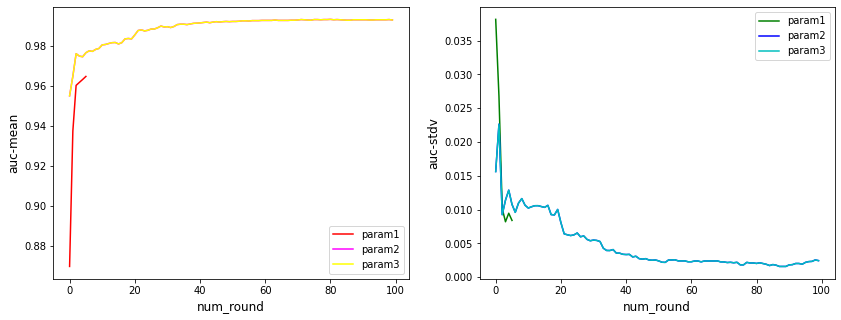

In [92]:
plot_mertics(cv_result1, cv_result2, cv_result3, index1=2, index2=3)

In [70]:
"""
当使用验证集，并加入早停机制时，可以设置在多少步之内，若评估指标不在下降
，则提前终止训练模型，多个评估指标使用时，每一个评估指标都可作为终止的条件
"""
lgb = lgb.train(params=params1, train_set=data_train, valid_sets=data_val
          , early_stopping_rounds=2
          , valid_names="valid"
         )

[LightGBM] [Info] Number of positive: 291, number of negative: 164
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4536
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: GeForce GTX 950M, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (0.01 MB) transferred to GPU in 0.000861 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.639560 -> initscore=0.573457
[LightGBM] [Info] Start training from score 0.573457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid's binary_logloss: 0.609003	valid's auc: 0.983586
Training until validation scores don't improve for 2 rounds
[LightGBM] [Warning] No furt

In [63]:
#  模型保存
joblib.dump(lgb, filename="./data/lgb_module.pkl")

['./data/lgb_module.pkl']

In [64]:
#  模型加载
lgb = joblib.load("data/lgb_module.pkl")

In [65]:
#  预测结果为概率
lgb.predict(X_val, num_iteration=lgb.best_iteration)

array([0.73536463, 0.6004293 , 0.46386763, 0.71961806, 0.50626208,
       0.46386761, 0.46392326, 0.71961806, 0.71947631, 0.51098993,
       0.46307189, 0.73488976, 0.6244425 , 0.51098993, 0.73563905,
       0.68333946, 0.73488976, 0.6004293 , 0.461521  , 0.6501919 ,
       0.71961806, 0.72626001, 0.51098993, 0.461521  , 0.46386762,
       0.51098993, 0.54120729, 0.6501919 , 0.70750289, 0.73488464,
       0.6256613 , 0.71961806, 0.46386761, 0.73488978, 0.51027232,
       0.46386761, 0.46392325, 0.6501919 , 0.46392324, 0.73488464,
       0.46846888, 0.6501919 , 0.73488975, 0.7350768 , 0.46307189,
       0.68789469, 0.70621144, 0.73563909, 0.6951938 , 0.461521  ,
       0.73488827, 0.70597839, 0.51098993, 0.73499298, 0.70597839,
       0.73536465, 0.73488978, 0.722619  , 0.71949473, 0.71961806,
       0.73488974, 0.7351638 , 0.73488978, 0.73488978, 0.59086174,
       0.73488974, 0.46846888, 0.73488974, 0.71326074, 0.45894334,
       0.50943083, 0.51569108, 0.46362123, 0.70597839, 0.73536

In [66]:
probs = lgb.predict(X_val, num_iteration=lgb.best_iteration) 
FPR, recall, thresholds = roc_curve(Y_val, probs, pos_label=1)
area = AUC(Y_val, probs)

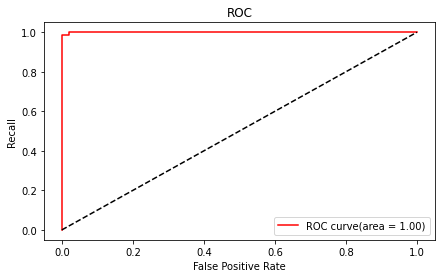

In [67]:
plt.figure(figsize=(7, 4))
plt.plot(FPR, recall, color="red",
         label = "ROC curve(area = %0.2f)" % area)
plt.plot([0, 1], [0, 1], c="black", linestyle = "--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
cancer = JJJ
X = cancer.data
Y = cancer.target

# 划分数据集
X_train, X_val, Y_train, Y_val = train_test_split(X, Y
                                                    , test_size = 0.2
                                                    , random_state=20
                                                   )

## 参考
[lightgbm GPU编译以及安装超详细讲解](https://blog.csdn.net/u012111465/article/details/106737899)
[LightGBM参数调优代码详解](https://blog.csdn.net/dzysunshine/article/details/92124011)  
[LightGBM调参笔记](https://blog.csdn.net/u012735708/article/details/83749703)  
[最简便的lightGBM GPU支持的安装、验证方法](https://blog.csdn.net/lccever/article/details/80535058#commentBox)  
[LightGBM算法总结](https://blog.csdn.net/weixin_39807102/article/details/81912566)  
[30分钟搞定数据竞赛刷分夺冠神器LightGBM](https://baijiahao.baidu.com/s?id=1651191646213921996&wfr=spider&for=pc)  
[『我爱机器学习』集成学习（四）LightGBM](https://www.hrwhisper.me/machine-learning-lightgbm/)